# Pre-ensemble

In [4]:
import random
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
import bisect
import copy
import json
import csv
import ast
import time
from scipy import special

# Import data

In [8]:
# Categorize cases by linear vs branched
branched_cases_ID=['04','05','06','09',100,101,112,118,12,120,121,123,13,14,21,22,26,28,31,32,38,39,40,41,42,45,46,51,61,62,63,66,67,69,70,71,\
               74,75,76,78,79,81,82,83,84,85,87,88,89,90,91,92,94,95,96,97,99]
branched_cases=[]
linear_cases = []
for sample_label in all_persons.keys():
    cc = 0
    ID = sample_label.split('-')[1]
#     print(ID)
    for num in branched_cases_ID:
        if str(num) == ID:
            cc+=1
    if cc == 0:
#         print(sample_label , 'is linear')
        linear_cases.append(sample_label)
    else:
        branched_cases.append(sample_label)
#         print(sample_label)
print('linear cases', len(linear_cases))
print('branched cases', len(branched_cases))

linear cases 66
branched cases 57


In [171]:
import pandas as pd
  
# columns = [int(c) for c in np.linspace(0,150402+1,150402)]
df = pd.read_csv('Morita_et_al_mutation_data_123_patients.csv')

In [172]:
all_persons = {}
all_persons_cell_number = {}
for row in range(543):
    extracted_row = df.loc[row] 
    sample_label = extracted_row[0]
    gene_mutated = extracted_row[1]
    aa_change = extracted_row[6]
    cell_fraction = extracted_row[9]
    VAF = extracted_row[10]
    genotyped_cells = int(extracted_row[10])+int(extracted_row[11])+int(extracted_row[12])
    total_cell_number = int(extracted_row[10])+int(extracted_row[11])+int(extracted_row[12])+int(extracted_row[13])
#     print(gene_mutated, aa_change, genotyped_cells)
    if sample_label not in all_persons.keys():
        this_person = {}
#     this_person[str(gene_mutated)]= float(cell_fraction)
    this_person[str(gene_mutated)+str(aa_change)]= float(cell_fraction)
    this_person = {k: v for k, v in sorted(this_person.items(), key=lambda item: item[1])}
    all_persons[sample_label]=this_person
    all_persons_cell_number[sample_label]=total_cell_number
print(this_person)

{'RUNX1p.R204X': 0.420697859, 'DNMT3Ap.R882C': 0.631245044, 'U2AF1p.S34F': 0.649881047, 'TET2p.H717fs': 0.706185567}


In [170]:
DNMT3A_NPM1_cases = 0
DNMT3A_NPM1_cases_labels = []
for sample_label, cell_fraction_vector in all_persons.items():
    total_cell_number = all_persons_cell_number[sample_label]
    if 'DNMT3A' in cell_fraction_vector.keys() and 'NPM1' in cell_fraction_vector.keys():
        DNMT3A_NPM1_cases += 1
        DNMT3A_NPM1_cases_labels.append(sample_label)
#         print(sample_label)

print('DNMT3A_NPM1_cases', DNMT3A_NPM1_cases)

DNMT3A_NPM1_cases 20


Extract clone size vectors for linear cases only. Since the progression is linear, the widtype clonal freqeuncy is

$f_0=1-\sum_{i=1}^{k} f_i$

Mutation inferred from SCITE vs mutation in order of descending VAF in pseudo-bulk are not always the same but k is the same as number of mutation in psuedo-bulk list i.e. no extra side branch mutations pop up in psuedo-bulk.

In [200]:
mutation_order_in_amb_linear_cases = {
'AML-02-001':{'main_branch':['DNMT3Ap.R882H','SF3B1p.K666N', 'FLT3p.D835V', 'RUNX1p.S141fs'], 'divergent_level_mutants':[]},
    'AML-24-001':{'main_branch':['WT1p.C453Y','DNMT3Ap.R882H','NRAS','NPM1'], 'divergent_level_mutants':[]}, # not psuedo bulk cf for some mutations
    'AML-25-001':{'main_branch':['RUNX1p.Q335X','FLT3p.E596fs', 'FLT-ITD'], 'divergent_level_mutants':[]},# same as above
    'AML-29-001':{'main_branch':['SRSF2p.P95H','RUNX1p.R201Q','IDH2p.R140Q'], 'divergent_level_mutants':[]},
    'AML-59-001':{'main_branch':['IDH1p.R132C','RUNX1p.K152fs','DNMT3Ap.R882H'], 'divergent_level_mutants':[]},
    'AML-60-001':{'main_branch':['IDH2p.R140Q','SRSF2p.P95H', 'FLT3p.E604delinsERFREYEYDLKWEFPRENLE'], 'divergent_level_mutants':[]},
    'AML-64-001':{'main_branch':['IDH2p.R140Q','DNMT3Ap.R882H','SRSF2p.P95H', 'NRASp.Q61K'], 'divergent_level_mutants':[]},
    'AML-98-001':{'main_branch':['BCORp.Q1624X','PTPN11p.A72T', 'KITp.D816V', 'RUNX1p.A147_T148insKLRNA'], 'divergent_level_mutants':[]},
    'AML-102-001':{'main_branch':['FLT3p.D835Y','WT1p.R380fs','DNMT3Ap.R882H','NPM1p.L287fs'], 'divergent_level_mutants':[]},
    'AML-111-001':{'main_branch':['SETBP1p.D868N', 'RUNX1p.G165R', 'ASXL1p.P935fs'], 'divergent_level_mutants':[]}
}

In [210]:
# infer clone size from cell fraction difference
clone_size_vectors_of_linear_cases = {}
df = pd.DataFrame(columns=['$n_0$','$n_1$','$n_2$','$n_3$','$n_4$','k', 'sample_label'])
j = 0
for sample_label in linear_cases:
    
    og_cell_fraction_vector = all_persons[sample_label]

    
    cell_fraction_vector = list(og_cell_fraction_vector.values())[::-1]

    clone_size_vector = []
    for i in range(len(cell_fraction_vector)-1):
        clone_size_vector.append(cell_fraction_vector[i]-cell_fraction_vector[i+1])
    clone_size_vector.append(cell_fraction_vector[len(cell_fraction_vector)-1])

    if sample_label not in ['AML-16-001','AML-17-001', 'AML-34-001', 'AML-37-001', 'AML-54-001', 'AML-57-001', 'AML-73-001', 'AML-113-001']:
        if sample_label in ['AML-02-001','AML-64-001','AML-98-001', 'AML-102-001']:
        
            focus_list = mutation_order_in_amb_linear_cases[sample_label]['main_branch']     
            selected_cell_fraction_vector = {}
            for k, v in og_cell_fraction_vector.items():
                if k in focus_list:
                    selected_cell_fraction_vector[k]=v
            cell_fraction_vector = list(selected_cell_fraction_vector.values())[::-1]
            clone_size_vector = []
            for i in range(len(cell_fraction_vector)-1):
                clone_size_vector.append(cell_fraction_vector[i]-cell_fraction_vector[i+1])
            clone_size_vector.append(cell_fraction_vector[len(cell_fraction_vector)-1])
            
            wt_f = 1-clone_size_vector[0]- clone_size_vector[1]-clone_size_vector[2]-clone_size_vector[3]
            df.loc[j] = [wt_f,clone_size_vector[0], clone_size_vector[1],clone_size_vector[2],clone_size_vector[3],'4',sample_label] 
            j+=1
        if len(clone_size_vector) == 3:
            wt_f = 1-clone_size_vector[0]- clone_size_vector[1]-clone_size_vector[2]
            df.loc[j] = [wt_f,clone_size_vector[0], clone_size_vector[1],clone_size_vector[2],'NaN','3',sample_label] 
            j+=1

        if len(clone_size_vector) == 4:

            if sample_label in ['AML-29-001','AML-59-001','AML-60-001','AML-111-001']:
                focus_list = mutation_order_in_amb_linear_cases[sample_label]['main_branch']     
                selected_cell_fraction_vector = {}
                for k, v in og_cell_fraction_vector.items():
                    if k in focus_list:
                        selected_cell_fraction_vector[k]=v
                cell_fraction_vector = list(selected_cell_fraction_vector.values())[::-1]

                clone_size_vector = []
                for i in range(len(cell_fraction_vector)-1):
                    clone_size_vector.append(cell_fraction_vector[i]-cell_fraction_vector[i+1])
                clone_size_vector.append(cell_fraction_vector[len(cell_fraction_vector)-1])
            
                wt_f = 1-clone_size_vector[0]- clone_size_vector[1]-clone_size_vector[2]
                df.loc[j] = [wt_f,clone_size_vector[0], clone_size_vector[1],clone_size_vector[2],'NaN','3',sample_label]
                j+=1
            else:
                wt_f = 1-clone_size_vector[0]- clone_size_vector[1]-clone_size_vector[2]-clone_size_vector[3]
                df.loc[j] = [wt_f,clone_size_vector[0], clone_size_vector[1],clone_size_vector[2],clone_size_vector[3],'4',sample_label]
                j+=1
    #         print(sample_label, 'clone_size_vector',  [wt_f,clone_size_vector[0], clone_size_vector[1],clone_size_vector[2],clone_size_vector[3]])
            
#     print('j :', j)
    clone_size_vectors_of_linear_cases[sample_label] = clone_size_vector
    
# df.to_csv('dataframes_for_distance_metrics/Morita_linear_cases_clone_size_vectors_after_manual_filtering.csv', sep=',', index=False, encoding='utf-8')


27 14


Text(0.5, 1.0, 'Linear cases from Morita et al.')

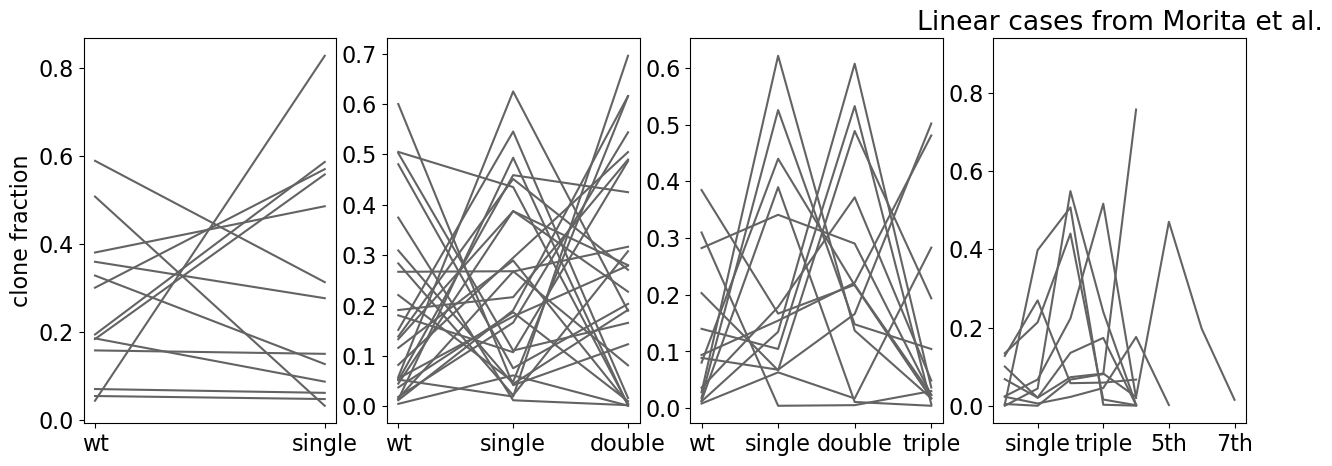

In [84]:
import matplotlib.pyplot as plt
import matplotlib
import numpy


plt.clf()
plt.close('all')
f, ax = plt.subplots(1,4, figsize=(15,5))
font = {'weight' : 'normal','size'   : 16}
matplotlib.rc('font', **font)
f.subplots_adjust(hspace=0.4)

three_hit_cases=0
four_hit_cases=0
mutant_labels = ['wt', 'single', 'double', 'triple', '4th', '5th', '6th', '7th']
for label,tree in clone_size_vectors_of_linear_cases.items():
    if len(tree) == 2:
        n = 0
    if len(tree) == 3:
        n = 1
        three_hit_cases+=1
    if len(tree) == 4:
        n = 2
        four_hit_cases+=1
    if len(tree) >4:
        n = 3
    ax[n].plot(range(len(tree)), tree, label=label, color = grey4)
    ax[n].set_xticks(range(len(tree)))
    ax[n].set_xticklabels(mutant_labels[0:len(tree)])
    if n ==3:
        ax[n].set_xticks([1,3,5,7])
        ax[n].set_xticklabels(['single', 'triple','5th',  '7th'])
    
    ax[0].set_ylabel('clone fraction')



print(three_hit_cases, four_hit_cases)  
    
plt.title('Linear cases from Morita et al.')
# plt.savefig('My_graphs/visualization_of_linear_cases_from_morita.pdf', bbox_inches = 'tight')
# ax.show()

Extract branched cases

In [2]:
import pandas as pd
  
# columns = [int(c) for c in np.linspace(0,150402+1,150402)]
df = pd.read_csv('Morita_et_al_mutation_data_123_patients.csv')
all_persons = {}
all_persons_cell_number = {}
for row in range(543):
    extracted_row = df.loc[row] 
    sample_label = extracted_row[0]
    gene_mutated = extracted_row[1]
    aa_change = extracted_row[6]
    cell_fraction = extracted_row[9]
    VAF = extracted_row[10]
    genotyped_cells = int(extracted_row[10])+int(extracted_row[11])+int(extracted_row[12])
    total_cell_number = int(extracted_row[10])+int(extracted_row[11])+int(extracted_row[12])+int(extracted_row[13])
#     print(gene_mutated, aa_change, genotyped_cells)
    if sample_label not in all_persons.keys():
        this_person = {}
    this_person[str(gene_mutated)+'_'+str(aa_change)]= float(cell_fraction)
#     this_person[str(gene_mutated)+str(aa_change)]= float(cell_fraction)
    this_person = {k: v for k, v in sorted(this_person.items(), key=lambda item: item[1])}
    all_persons[sample_label]=this_person
    all_persons_cell_number[sample_label]=total_cell_number
print(this_person)

{'RUNX1_p.R204X': 0.420697859, 'DNMT3A_p.R882C': 0.631245044, 'U2AF1_p.S34F': 0.649881047, 'TET2_p.H717fs': 0.706185567}


The mutations called in pseudo bulk is often just a subset of the tree nodes. In particular small side brnches are not recorded in pseudo-bulk. Hence it is better to simply treat the branched fraction in the same way as the wild type fraction. With SCITE, the inferred mutation order is occasionally not in descending order of psuedo-bulk VAF, which raises concerns about reliability of the algorithm but supports why we should not model base on exact mutation identities.

In [1]:
# main branch is defined as the longest branch, if same length then choose the one with a larger node. some mutation information is missing from pseudo-bulk mutation list
mutation_order_in_branched_cases = {
'AML-04-001':{'main_branch':['SF3B1_p.K666N', 'SRSF2_p.P95H','FLT3_p.F590delinsLMVQVTGSSDNEYF','PTPN11_p.F71L'], 'divergent_level_mutants':['FLT3_p.D835E','NRAS_p.G12D']},
'AML-05-001':{'main_branch':[],'divergent_level_mutants':[]},   # k=1
'AML-06-001':{'main_branch':[],'divergent_level_mutants':[]},   # k=1
'AML-09-001':{'main_branch':['NPM1_p.L287fs', 'FLT3_p.D835Y', 'WT1'], 'divergent_level_mutants':['FLT3_p.F590_Y591delinsLVLLRX', 'KRAS_p.G13D','FLT3_p.D835E']},
'AML-12-001':{'main_branch':[],'divergent_level_mutants':[]},  # k=2
'AML-13-001':{'main_branch':['IDH2_p.R140Q', 'WT1_p.R462P', 'NPM1_p.L287fs'],'divergent_level_mutants':['TP53_p.V172fs']},
'AML-14-001':{'main_branch':[],'divergent_level_mutants':[]},  # k=2
'AML-21-001':{'main_branch':['WT1_p.A382fs', 'NPM1_p.L287fs', 'NRAS_p.G12D'],'divergent_level_mutants':['FLT3-ITD']},
'AML-22-001':{'main_branch':[],'divergent_level_mutants':[]},   # k=1 according to SCITE despite many mutations
'AML-26-001':{'main_branch':[ 'DNMT3A_p.R882H', 'NPM1_p.L287fs', 'FLT3_p.D835A'],'divergent_level_mutants':['FLT3_p.D835Y','KRAS_p.Q61L', 'NRAS_p.G13D']},
'AML-28-001':{'main_branch':['DNMT3A_p.R882C', 'IDH1_p.R132H', 'NPM1_p.L287fs','FLT3_p.V592fs'],'divergent_level_mutants':['GATA2', 'RUNX1']},
'AML-31-001':{'main_branch':[],'divergent_level_mutants':[]},  # k=2
'AML-32-001':{'main_branch':['DNMT3A_p.R882H','SF3B1_p.K700E', 'RUNX1_p.R166G',  'FLT3_p.D835Y'],'divergent_level_mutants':['FLT3_p.V581fs']},
'AML-38-001':{'main_branch':['NPM1_p.L287fs', 'IDH1_p.R132H', 'KRAS_p.G12A'], 'divergent_level_mutants':['IDH2_p.R140Q','PTPN11_p.D61H']}, # k=3 or 4 unlikely k=4
'AML-39-001':{'main_branch':[],'divergent_level_mutants':[]}, # k=2
'AML-40-001':{'main_branch':['IDH2_p.R140Q','NPM1_p.L287fs','NRAS_p.G12D'],'divergent_level_mutants':['FLT3_p.N676K']},
'AML-41-001':{'main_branch':['TP53_p.N235S', 'WT1_p.R369X', 'IDH2_p.R140Q','SRSF2_p.P95H',  'KRAS_p.G12A'],'divergent_level_mutants':['NRAS_p.G12A','PTPN11_p.A72T','PTPN11_p.D61H']},
'AML-42-001':{'main_branch':['EZH2_p.R676H', 'STAG2_p.N1046fs', 'RUNX1_p.A142fs', 'NRAS_p.G12D'], 'divergent_level_mutants':['BCOR', 'RUNX1_p.I366fs']},
'AML-45-001':{'main_branch':[],'divergent_level_mutants':[]},  # k=2
'AML-46-001':{'main_branch':['BCOR_p.N1628fs','PTPN11_p.A72T','NPM1_p.L287fs'],  'divergent_level_mutants':[]},
'AML-51-001':{'main_branch':['DNMT3A_p.R882C', 'NPM1_p.L287fs','FLT3_p.D835Y'],'divergent_level_mutants':['FLT3_p.F612delinsYFYVDFREYEYV','NRAS_p.G12V']},
'AML-61-001':{'main_branch':[],'divergent_level_mutants':[]},   # k=2
'AML-62-001':{'main_branch':['NPM1_p.L287fs', 'IDH1_p.R132H', 'PTPN11_p.F71L'],'divergent_level_mutants':['PTPN11_p.A72T','FLT3_p.T582delinsIGA']},
'AML-63-001':{'main_branch':['IDH2_p.R140Q','NPM1_p.L287fs','KIT_p.D816V'],'divergent_level_mutants':['FLT3_p.S585fs']},
'AML-66-001':{'main_branch':[],'divergent_level_mutants':[]},   # k=2
'AML-67-001':{'main_branch':['DNMT3A_p.F732fs','ASXL1_p.S770X', 'STAG2_p.Y636_H637delinsX', 'BCOR_p.G1474fs','U2AF1_p.S34F', 'NRAS_p.G12S'],'divergent_level_mutants':[ 'BCOR_p.Q1592X', 'KRAS_p.Q61H']}, #very complicated tree of which only some mutations have freq info
'AML-69-001':{'main_branch':[],'divergent_level_mutants':[]},  # k=2
'AML-70-001':{'main_branch':['IDH2_p.R140Q', 'KRAS_p.D33E', 'SRSF2_p.P95L', 'KRAS_p.D33E'], 'divergent_level_mutants':['NRAS_p.G60E']},
'AML-71-001':{'main_branch':['TET2_splicing', 'DNMT3A_splicing','ASXL1_p.S795fs', 'NRAS_p.G12R', 'RUNX1_p.P301fs'],'divergent_level_mutants':['NF1']},
'AML-74-001':{'main_branch':[],'divergent_level_mutants':[]},   # k=2
'AML-75-001':{'main_branch':[],'divergent_level_mutants':[]},  # k=2
'AML-76-001':{'main_branch':['U2AF1_p.S34F','DNMT3A_p.R882P' ,'NRAS_p.Q61H'],'divergent_level_mutants':['FLT3_p.836_837del','FLT3_p.G583fs']},
'AML-78-001':{'main_branch':[],'divergent_level_mutants':[]},    # k=1
'AML-79-001':{'main_branch':[],'divergent_level_mutants':[]},    # k=1
'AML-81-001':{'main_branch':[],'divergent_level_mutants':[]},    # k=1 according to SCITE despite many mutations
'AML-82-001':{'main_branch':['DNMT3A_p.R882C', 'IDH1_p.R132H',  'NPM1_p.L287fs','PTPN11_p.E76V'],'divergent_level_mutants':['FLT3_p.D835Y']},
'AML-83-001':{'main_branch':['DNMT3A_p.V763fs', 'IDH2_p.R172K', 'FLT3'],'divergent_level_mutants':['NRAS']},
'AML-84-001':{'main_branch':['PHF6_p.N171fs', 'IDH2_p.R140Q','FLT3_p.F612fs'],'divergent_level_mutants':['FLT3 2']},
'AML-85-001':{'main_branch':[],'divergent_level_mutants':[]},    # k=1
'AML-87-001':{'main_branch':['WT1_p.A382fs', 'FLT3_p.D600fs', 'MYC_p.P74Q', 'WT1_p.R462W'],'divergent_level_mutants':[]},
'AML-88-001':{'main_branch':['SF3B1_p.K666R','TET2_p.S1267X', 'DNMT3A_p.R882H', 'NPM1_p.L287fs', 'FLT3_p.834_835del'],'divergent_level_mutants':['FLT3_p.D835V']},
'AML-89-001':{'main_branch':[],'divergent_level_mutants':[]},    # k=1
'AML-90-001':{'main_branch':['SF3B1_p.K666N', 'NRAS_p.G12D', 'NPM1_p.L287fs', 'PHF6_p.R274Q'],'divergent_level_mutants':['ETV']},
'AML-91-001':{'main_branch':['TET2_p.Q1567X', 'ASXL1_p.T844fs', 'RUNX1_p.R320fs','KIT_p.D816V', 'SRSF2_p.P95R'], 'divergent_level_mutants':['PTPN11_p.A72V','NRAS 1', 'NAS 2']},
'AML-92-001':{'main_branch':['RUNX1_p.R204Q', 'JAK2_p.V617F', 'IDH1_p.R132C', 'SRSF2'],'divergent_level_mutants':['IDH1_p.R132H', 'TET2_p.P1638fs']},
'AML-94-001':{'main_branch':['IDH1_p.R132C', 'STAG2_p.Y636_H637delinsX', 'SRSF2_p.P95R'],'divergent_level_mutants':['BCOR_p.R1183X']},
'AML-95-001':{'main_branch':[],'divergent_level_mutants':[]},  # k=1
'AML-96-001':{'main_branch':[],'divergent_level_mutants':[]},    # k=2
'AML-97-001':{'main_branch':[ 'DNMT3A_p.R882H', 'NRAS_p.G13D', 'NPM1_p.L287fs'], 'divergent_level_mutants':[]},
'AML-99-001':{'main_branch':['DNMT3A_p.R882H', 'IDH2_p.R140Q', 'RUNX1_p.R162K', 'IDH1', 'RUNX1_p.S318fs', 'CSF3R_p.Q768X'],'divergent_level_mutants':['many']},
'AML-100-001':{'main_branch':['DNMT3A_p.R882H','PTPN11_p.Q79R', 'IDH2_p.R140Q', 'NPM1_p.L287fs','FLT3_p.V592fs'],'divergent_level_mutants':['NRAS_p.G13D']},
'AML-101-001':{'main_branch':['TP53_p.V143M','TP53_p.Y220C', 'PTPN11 G503V', 'PTPN11 G503R'], 'divergent_level_mutants':['KMD6A','KRAS_p.G13D']},  #if mutant not available, assume belongs to blast
'AML-112-001':{'main_branch':['TET2_p.N483fs', 'DNMT3A_p.R882H', 'KIT_p.D816V'],'divergent_level_mutants':['TET2_p.R1387fs','NPM1_p.L287fs']},
'AML-118-001':{'main_branch':['TET2_p.E1255X',  'SRSF2_p.P95R','TET2 568fs', 'TET2 574X'],'divergent_level_mutants':['SMC1A']},
'AML-120-001':{'main_branch':['SF3B1_p.K666N', 'NPM1', 'RUNX1_p.P425fs'],'divergent_level_mutants':['TET2']},
'AML-121-001':{'main_branch':['NPM1_p.L287fs', 'DNMT3A_p.R882H','FLT3_p.D835H'],'divergent_level_mutants':['KRAS_p.G12D']},
'AML-123-001':{'main_branch':[ 'DNMT3A_p.R882C', 'TET2_p.H717fs', 'U2AF1_p.S34F', 'RUNX1_p.R204X', 'EZH2'],'divergent_level_mutants':['TP53']},
}

Extract clone size vectors for linear cases only. Since the progression is branched, 

$f_0=1-\sum_{i=1}^{k} f_i$ is the sum of wild type frequency and side branch freqeuncy

In [17]:
# infer clone size from cell fraction difference
clone_size_vectors_of_branched_cases = {}
df = pd.DataFrame(columns=['$n_0$','$n_1$','$n_2$','$n_3$','$n_4$','k', 'sample_label'])

j = 0
for sample_label in branched_cases:

    og_cell_fraction_vector = all_persons[sample_label]

#     main_branch_dictionary = {}
#     for mutated_gene, cell_fraction in cell_fraction_vector.items():
        
#         if mutated_gene in mutation_order_in_branched_cases[sample_label]:
#             # check if same gene is mutated multiple times in one person
#             if mutated_gene in main_branch_dictionary.keys():
#                 print('gene mutation twice', mutated_gene, 'in sample', sample_label)
#             main_branch_dictionary[mutated_gene]=cell_fraction                        
#     print('main_branch_dictionary', main_branch_dictionary)
    
    focus_list = mutation_order_in_branched_cases[sample_label]['main_branch']    
    if len(focus_list)!=0:
        selected_cell_fraction_vector = {}
        for k, v in og_cell_fraction_vector.items():
            if k in focus_list:
                selected_cell_fraction_vector[k]=v
        cell_fraction_vector = list(selected_cell_fraction_vector.values())[::-1]

        clone_size_vector = []
        for i in range(len(cell_fraction_vector)-1):
            clone_size_vector.append(cell_fraction_vector[i]-cell_fraction_vector[i+1])
        clone_size_vector.append(cell_fraction_vector[len(cell_fraction_vector)-1])


        if len(clone_size_vector) == 3:
            wt_f = 1-clone_size_vector[0]- clone_size_vector[1]-clone_size_vector[2]
            df.loc[j] = [wt_f,clone_size_vector[0], clone_size_vector[1],clone_size_vector[2],'NaN','3',sample_label] 
            print('clone_size_vector', [wt_f,clone_size_vector[0], clone_size_vector[1],clone_size_vector[2]])
            j+=1
        if len(clone_size_vector) == 4:
            wt_f = 1-clone_size_vector[0]- clone_size_vector[1]-clone_size_vector[2]-clone_size_vector[3]
            df.loc[j] = [wt_f,clone_size_vector[0], clone_size_vector[1],clone_size_vector[2],clone_size_vector[3],'4',sample_label] 
            print('clone_size_vector',  [wt_f,clone_size_vector[0], clone_size_vector[1],clone_size_vector[2],clone_size_vector[3]])
            j+=1
    #     print('j :', j)
        clone_size_vectors_of_branched_cases[sample_label] = clone_size_vector
    
# df.to_csv('dataframes_for_distance_metrics/Morita_branched_cases_clone_size_vectors_after_manual_filtering.csv', sep=',', index=False, encoding='utf-8')


clone_size_vector [0.07320000000000007, 0.1885, 0.17379999999999995, 0.4488, 0.1157]
clone_size_vector [0.5391, 0.17079999999999995, 0.08640000000000003, 0.2037]
clone_size_vector [0.07650000000000001, 0.33119999999999994, 0.08340000000000003, 0.5089]
clone_size_vector [0.4735000000000001, 0.34969999999999996, 0.07330000000000002, 0.1035]
clone_size_vector [0.22089999999999996, 0.06140000000000001, 0.2731, 0.3425, 0.1021]
clone_size_vector [0.14629999999999999, 0.16880000000000006, 0.008599999999999941, 0.058499999999999996, 0.6178]
clone_size_vector [0.3988, 0.0928, 0.12869999999999998, 0.3797]
clone_size_vector [0.19260000000000005, 0.3634, 0.15500000000000003, 0.289]
clone_size_vector [0.11755817499999999, 0.831368993, 0.008461771, 0.030825023, 0.011786038]
clone_size_vector [0.12292490099999998, 0.013636364000000012, 0.343478261, 0.519960474]
clone_size_vector [0.14529999999999998, 0.19510000000000005, 0.38239999999999996, 0.2772]
clone_size_vector [0.13560000000000005, 0.417699999